In [1]:
using Distributed
addprocs(8);

In [2]:
@everywhere using PulseInputDDM
using Flatten, MAT

In [3]:
import Base.Iterators: partition

In [4]:
import PulseInputDDM: choice_null

In [5]:
ratnames = ["B068","T034","T036","T063","T030", "T035","T011","B053", "T080","T103","E021"];
dt, n, cross = 1e-2, 53, false
data_path = joinpath(abspath(joinpath(pwd(), "..")), "data/by_session_w_cpoke")

"/Users/briandepasquale/Documents/GitHub/DePasquale-eLife-2024/data/by_session_w_cpoke"

## PPC

In [6]:
region, delay = "PPC", 12
ratnum = 6:8
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_PPC, μ_rnt, μ_t, cpoke_out_PPC = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, filtSD=5,
    do_RBF=true);

## ADS

In [7]:
region, delay = "ADS", 6
ratnum = 9:11
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_STR, μ_rnt, μ_t, cpoke_out_STR = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, filtSD=5,
    do_RBF=true);

## FOF

In [8]:
region, delay = "FOF", 6
ratnum = 1:5
rat = ratnames[ratnum]
sessions = vcat(map(rat-> filter(x->occursin(rat,x), readdir(data_path)), rat)...);
data_FOF, μ_rnt, μ_t, cpoke_out_FOF = load_neural_data(joinpath.(data_path, sessions), pcut=0.01, pad=20, delay=delay, dt=dt, filtSD=5,
    do_RBF=true);

## Joint CV

In [9]:
joint_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/joint-folds");

In [10]:
LL_joint_PPC_folds = Vector{Float64}(undef,5)
joint_model_folds_PPC = Vector(undef,5)
test_data_folds_PPC = Vector(undef,5)
region = "PPC"
ntrials = length.(data_PPC);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_PPC = map((data, train)-> data[train], data_PPC, test)

    file = joinpath(joint_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    f = all_Softplus(data_PPC)  

    test_data_folds_PPC[fold] = test_data_PPC
    joint_model_folds_PPC[fold] = neural_choiceDDM(θneural_choice(xfolds, f), n, cross);

    LL_joint_PPC_folds[fold] = (PulseInputDDM.choice_loglikelihood(joint_model_folds_PPC[fold], test_data_PPC) - 
        choice_null(getfield.(vcat(test_data_PPC...), :choice)))/(log(2) * 
        length(getfield.(vcat(test_data_PPC...), :choice)));
end

In [11]:
LL_joint_STR_folds = Vector{Float64}(undef,5)
joint_model_folds_STR = Vector(undef,5)
test_data_folds_STR = Vector(undef,5)
region = "ADS"
ntrials = length.(data_STR);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_STR = map((data, train)-> data[train], data_STR, test)

    file = joinpath(joint_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    f = all_Softplus(data_STR)  

    test_data_folds_STR[fold] = test_data_STR
    joint_model_folds_STR[fold] = neural_choiceDDM(θneural_choice(xfolds, f), n, cross);

    LL_joint_STR_folds[fold] = (PulseInputDDM.choice_loglikelihood(joint_model_folds_STR[fold], test_data_STR) - 
        choice_null(getfield.(vcat(test_data_STR...), :choice)))/(log(2) * 
        length(getfield.(vcat(test_data_STR...), :choice)));
end

In [12]:
LL_joint_FOF_folds = Vector{Float64}(undef,5)
joint_model_folds_FOF = Vector(undef,5)
test_data_folds_FOF = Vector(undef,5)

region = "FOF"
ntrials = length.(data_FOF);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_FOF = map((data, train)-> data[train], data_FOF, test)

    file = joinpath(joint_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");
    f = all_Softplus(data_FOF)  

    test_data_folds_FOF[fold] = test_data_FOF
    joint_model_folds_FOF[fold] = neural_choiceDDM(θneural_choice(xfolds, f), n, cross);

    LL_joint_FOF_folds[fold] = (PulseInputDDM.choice_loglikelihood(joint_model_folds_FOF[fold], test_data_FOF) - 
        choice_null(getfield.(vcat(test_data_FOF...), :choice)))/(log(2) * 
        length(getfield.(vcat(test_data_FOF...), :choice)));
end

## Choice CV

In [13]:
choice_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/choice-folds");

In [14]:
choice_inputs = map(x-> map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(x, :input_data)), data_FOF);
choice_data_FOF_2 = map((x,y)-> PulseInputDDM.choicedata.(y, getfield.(x, :choice)), data_FOF, choice_inputs);
ntrials = length.(choice_data_FOF_2);

In [15]:
LL_choice_FOF_folds = Vector{Float64}(undef,5)
choice_model_folds_FOF = Vector(undef,5)
test_data_choice_folds_FOF = Vector(undef,5)

region = "FOF"

for fold in 1:5
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_FOF = map((data, train)-> data[train], choice_data_FOF_2, test)
    test_data_FOF = vcat(test_data_FOF...);

    file = joinpath(choice_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");

    test_data_choice_folds_FOF[fold] = test_data_FOF
    choice_model_folds_FOF[fold] = choiceDDM(θ = Flatten.reconstruct(θchoice(), xfolds), n=n, cross=cross);

    LL_choice_FOF_folds[fold] = (PulseInputDDM.loglikelihood(choice_model_folds_FOF[fold], test_data_FOF) - 
        choice_null(getfield.(test_data_FOF, :choice)))/(log(2) * length(getfield.(test_data_FOF, :choice)))
end

In [16]:
choice_inputs = map(x-> map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(x, :input_data)), data_PPC);
choice_data_PPC_2 = map((x,y)-> PulseInputDDM.choicedata.(y, getfield.(x, :choice)), data_PPC, choice_inputs);
ntrials = length.(choice_data_PPC_2);

In [17]:
LL_choice_PPC_folds = Vector{Float64}(undef,5)
choice_model_folds_PPC = Vector(undef,5)
test_data_choice_folds_PPC = Vector(undef,5)
region = "PPC"

for fold in 1:5
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_PPC = map((data, train)-> data[train], choice_data_PPC_2, test)
    test_data_PPC = vcat(test_data_PPC...);

    file = joinpath(choice_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");

    test_data_choice_folds_PPC[fold] = test_data_PPC
    choice_model_folds_PPC[fold] = choiceDDM(θ = Flatten.reconstruct(θchoice(), xfolds), n=n, cross=cross);

    LL_choice_PPC_folds[fold] = (PulseInputDDM.loglikelihood(choice_model_folds_PPC[fold], test_data_PPC) - 
        choice_null(getfield.(test_data_PPC, :choice)))/(log(2) * length(getfield.(test_data_PPC, :choice)))
end

In [18]:
choice_inputs = map(x-> map(x-> PulseInputDDM.choiceinputs(clicks=x.clicks, binned_clicks=x.binned_clicks, 
    dt=dt, centered=false), getfield.(x, :input_data)), data_STR);
choice_data_STR_2 = map((x,y)-> PulseInputDDM.choicedata.(y, getfield.(x, :choice)), data_STR, choice_inputs);
ntrials = length.(choice_data_STR_2);

In [19]:
LL_choice_STR_folds = Vector{Float64}(undef,5)
choice_model_folds_STR = Vector(undef,5)
test_data_choice_folds_STR = Vector(undef,5)
region = "ADS"

for fold in 1:5
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_STR = map((data, train)-> data[train], choice_data_STR_2, test)
    test_data_STR = vcat(test_data_STR...);

    file = joinpath(choice_model_path, region*"_"*string(fold)*".mat")
    xfolds = read(matopen(file), "ML_params");

    test_data_choice_folds_STR[fold] = test_data_STR
    choice_model_folds_STR[fold] = choiceDDM(θ = Flatten.reconstruct(θchoice(), xfolds), n=n, cross=cross);

    LL_choice_STR_folds[fold] = (PulseInputDDM.loglikelihood(choice_model_folds_STR[fold], test_data_STR) - 
        choice_null(getfield.(test_data_STR, :choice)))/(log(2) * length(getfield.(test_data_STR, :choice)))
end

## GLMs

In [20]:
GLM_model_path = joinpath(abspath(joinpath(pwd(), "..")), "models/GLM-folds");

In [21]:
using DePasqualeElife2024

In [22]:
LL_GLM_PPC_folds = Vector{Float64}(undef,5)
short_LL_GLM_PPC_folds = Vector{Float64}(undef,5)
GLM_model_folds_PPC = Vector(undef,5)
short_GLM_model_folds_PPC = Vector(undef,5)
test_data_GLM_model_folds_PPC = Vector(undef,5)
test_data_short_GLM_model_folds_PPC = Vector(undef,5)
region = "PPC"
ntrials = length.(data_PPC);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_PPC = map((data, train)-> data[train], data_PPC, test)

    file = joinpath(GLM_model_path, region*"_GLM_x"*string(fold)*".mat")
    xfolds = read(matopen(file), "x");
    f = all_Softplus(data_PPC)  

    test_data_GLM_model_folds_PPC[fold] = test_data_PPC
    GLM_model_folds_PPC[fold] = neural_choice_GLM_DDM(θneural_choice_GLM(xfolds, f), n, cross);

    LL_GLM_PPC_folds[fold] = (DePasqualeElife2024.loglikelihood(GLM_model_folds_PPC[fold], test_data_PPC) - 
        choice_null(getfield.(vcat(test_data_PPC...), :choice)))/(log(2) * 
        length(getfield.(vcat(test_data_PPC...), :choice)));
    
    short_test_data_PPC = map(x-> map(x -> neuraldata(x.input_data, 
            map(y-> getindex(y, length(y) - 
                    (x.input_data.pad - x.input_data.delay) - 5 + 1:length(y) - 
                    (x.input_data.pad - x.input_data.delay)), x.spikes), 
            x.ncells, x.choice), x), test_data_PPC);
    
    file = joinpath(GLM_model_path, region*"_short_GLM_x"*string(fold)*".mat")
    xfolds = read(matopen(file), "x");

    short_GLM_model_folds_PPC[fold] = neural_choice_GLM_DDM(θneural_choice_GLM(xfolds, f), n, cross);
    test_data_short_GLM_model_folds_PPC[fold] = short_test_data_PPC

    short_LL_GLM_PPC_folds[fold] = (DePasqualeElife2024.loglikelihood(short_GLM_model_folds_PPC[fold], short_test_data_PPC) - 
        choice_null(getfield.(vcat(short_test_data_PPC...), :choice)))/(log(2) * 
        length(getfield.(vcat(short_test_data_PPC...), :choice)));
end

In [23]:
LL_GLM_FOF_folds = Vector{Float64}(undef,5)
short_LL_GLM_FOF_folds = Vector{Float64}(undef,5)

GLM_model_folds_FOF = Vector(undef,5)
short_GLM_model_folds_FOF = Vector(undef,5)

test_data_GLM_model_folds_FOF = Vector(undef,5)
test_data_short_GLM_model_folds_FOF = Vector(undef,5)

region = "FOF"
ntrials = length.(data_FOF);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_FOF = map((data, train)-> data[train], data_FOF, test)

    file = joinpath(GLM_model_path, region*"_GLM_x"*string(fold)*".mat")
    xfolds = read(matopen(file), "x");
    f = all_Softplus(data_FOF)  

    GLM_model_folds_FOF[fold] = neural_choice_GLM_DDM(θneural_choice_GLM(xfolds, f), n, cross);
    test_data_GLM_model_folds_FOF[fold] = test_data_FOF

    LL_GLM_FOF_folds[fold] = (DePasqualeElife2024.loglikelihood(GLM_model_folds_FOF[fold], test_data_FOF) - 
        choice_null(getfield.(vcat(test_data_FOF...), :choice)))/(log(2) * 
        length(getfield.(vcat(test_data_FOF...), :choice)));
    
    short_test_data_FOF = map(x-> map(x -> neuraldata(x.input_data, 
            map(y-> getindex(y, length(y) - 
                    (x.input_data.pad - x.input_data.delay) - 5 + 1:length(y) - 
                    (x.input_data.pad - x.input_data.delay)), x.spikes), 
            x.ncells, x.choice), x), test_data_FOF);
    
    file = joinpath(GLM_model_path, region*"_short_GLM_x"*string(fold)*".mat")
    xfolds = read(matopen(file), "x");

    short_GLM_model_folds_FOF[fold] = neural_choice_GLM_DDM(θneural_choice_GLM(xfolds, f), n, cross);
    test_data_short_GLM_model_folds_FOF[fold] = short_test_data_FOF

    short_LL_GLM_FOF_folds[fold] = (DePasqualeElife2024.loglikelihood(short_GLM_model_folds_FOF[fold], short_test_data_FOF) - 
        choice_null(getfield.(vcat(short_test_data_FOF...), :choice)))/(log(2) * 
        length(getfield.(vcat(short_test_data_FOF...), :choice)));
end

In [24]:
LL_GLM_STR_folds = Vector{Float64}(undef,5)
short_LL_GLM_STR_folds = Vector{Float64}(undef,5)

GLM_model_folds_STR = Vector(undef,5)
short_GLM_model_folds_STR = Vector(undef,5)

test_data_GLM_model_folds_STR = Vector(undef,5)
test_data_short_GLM_model_folds_STR = Vector(undef,5)

region = "ADS"
ntrials = length.(data_STR);

for fold in 1:5
    
    train = map(ntrials -> vcat(collect.(partition(1:ntrials, ceil(Int, ntrials/5)))[setdiff(1:5, fold)]...), ntrials)
    test = map((ntrials, train)-> setdiff(1:ntrials, train), ntrials, train)
    test_data_STR = map((data, train)-> data[train], data_STR, test)

    file = joinpath(GLM_model_path, region*"_GLM_x"*string(fold)*".mat")
    xfolds = read(matopen(file), "x");
    f = all_Softplus(data_STR)  

    GLM_model_folds_STR[fold] = neural_choice_GLM_DDM(θneural_choice_GLM(xfolds, f), n, cross);
    test_data_GLM_model_folds_STR[fold] = test_data_STR
    LL_GLM_STR_folds[fold] = (DePasqualeElife2024.loglikelihood(GLM_model_folds_STR[fold], test_data_STR) - 
        choice_null(getfield.(vcat(test_data_STR...), :choice)))/(log(2) * 
        length(getfield.(vcat(test_data_STR...), :choice)));
    
    short_test_data_STR = map(x-> map(x -> neuraldata(x.input_data, 
            map(y-> getindex(y, length(y) - 
                    (x.input_data.pad - x.input_data.delay) - 5 + 1:length(y) - 
                    (x.input_data.pad - x.input_data.delay)), x.spikes), 
            x.ncells, x.choice), x), test_data_STR);
    
    file = joinpath(GLM_model_path, region*"_short_GLM_x"*string(fold)*".mat")
    xfolds = read(matopen(file), "x");

    short_GLM_model_folds_STR[fold] = neural_choice_GLM_DDM(θneural_choice_GLM(xfolds, f), n, cross);
    test_data_short_GLM_model_folds_STR[fold]  = short_test_data_STR
    short_LL_GLM_STR_folds[fold] = (DePasqualeElife2024.loglikelihood(short_GLM_model_folds_STR[fold], short_test_data_STR) - 
        choice_null(getfield.(vcat(short_test_data_STR...), :choice)))/(log(2) * 
        length(getfield.(vcat(short_test_data_STR...), :choice)));
end

## choice LL

In [25]:
import Statistics: mean

In [26]:
LL_choice_FOF = mean(LL_choice_FOF_folds)
LL_choice_STR = mean(LL_choice_STR_folds)
LL_choice_PPC = mean(LL_choice_PPC_folds);

In [27]:
LLGLM_FOF = mean(LL_GLM_FOF_folds)
LLGLM_STR = mean(LL_GLM_STR_folds)
LLGLM_PPC = mean(LL_GLM_PPC_folds)

0.23512173063880612

In [28]:
short_LLGLM_FOF = mean(short_LL_GLM_FOF_folds)
short_LLGLM_STR = mean(short_LL_GLM_STR_folds)
short_LLGLM_PPC = mean(short_LL_GLM_PPC_folds)

0.25211420994190714

In [29]:
LL_joint_FOF = mean(LL_joint_FOF_folds)
LL_joint_STR = mean(LL_joint_STR_folds)
LL_joint_PPC = mean(LL_joint_PPC_folds);

## Fraction correct

In [30]:
acc_joint_PPC = mean(map((x,y)-> mean(vcat(choice_likelihood(y, x)...) .> 0.5), 
    test_data_folds_PPC, joint_model_folds_PPC));
acc_joint_FOF = mean(map((x,y)-> mean(vcat(choice_likelihood(y, x)...) .> 0.5), 
    test_data_folds_FOF, joint_model_folds_FOF));
acc_joint_STR = mean(map((x,y)-> mean(vcat(choice_likelihood(y, x)...) .> 0.5), 
    test_data_folds_STR, joint_model_folds_STR));

In [31]:
import DePasqualeElife2024: likelihood

In [32]:
accGLM_STR = mean(map((x,y)-> mean(vcat(DePasqualeElife2024.likelihood(x, y)...) .> 0.5), GLM_model_folds_STR, 
    test_data_GLM_model_folds_STR))
accGLM_FOF = mean(map((x,y)-> mean(vcat(DePasqualeElife2024.likelihood(x, y)...) .> 0.5), GLM_model_folds_FOF,
    test_data_GLM_model_folds_FOF))
accGLM_PPC = mean(map((x,y)-> mean(vcat(DePasqualeElife2024.likelihood(x, y)...) .> 0.5), GLM_model_folds_PPC,
    test_data_GLM_model_folds_PPC))

0.7432078392661974

In [33]:
short_accGLM_STR = mean(map((x,y)-> mean(vcat(DePasqualeElife2024.likelihood(x,y)...) .> 0.5), short_GLM_model_folds_STR,
    test_data_short_GLM_model_folds_STR))
short_accGLM_FOF = mean(map((x,y)-> mean(vcat(DePasqualeElife2024.likelihood(x,y)...) .> 0.5), short_GLM_model_folds_FOF,
    test_data_short_GLM_model_folds_FOF))
short_accGLM_PPC = mean(map((x,y)-> mean(vcat(DePasqualeElife2024.likelihood(x,y)...) .> 0.5), short_GLM_model_folds_PPC,
    test_data_short_GLM_model_folds_PPC))

0.7451869486669669

In [35]:
acc_choice_PPC = mean(map((x,y)-> mean(vcat(PulseInputDDM.likelihood(x,y)...) .> 0.5), choice_model_folds_PPC,
    test_data_choice_folds_PPC))

0.7511822178599983

In [37]:
acc_choice_FOF = mean(map((x,y)-> mean(vcat(PulseInputDDM.likelihood(x,y)...) .> 0.5), choice_model_folds_FOF,
    test_data_choice_folds_FOF))

0.7378266777944307

In [38]:
acc_choice_STR = mean(map((x,y)-> mean(vcat(PulseInputDDM.likelihood(x,y)...) .> 0.5), choice_model_folds_STR,
    test_data_choice_folds_STR))

0.7727489277466183

In [39]:
using PyPlot

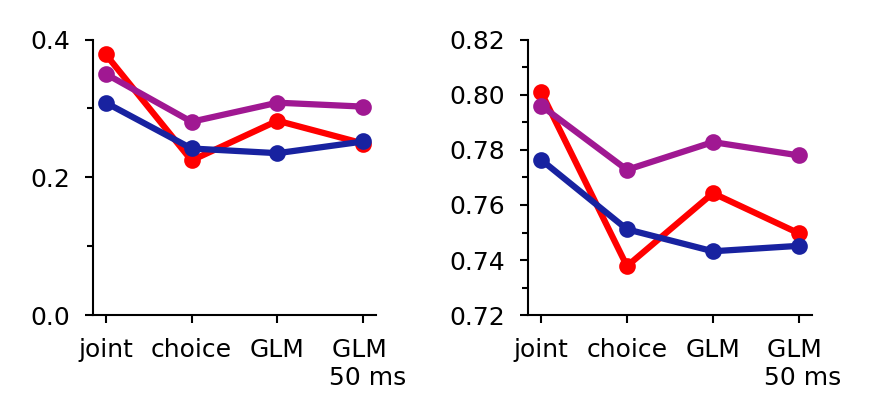

In [41]:
fig, ax = subplots(1, 2, figsize=(3.0, 1.5), dpi=300, frameon=true)

fs = 6

mycolors = ["red", "#1822A0", "#A01892"]
rc("xtick", labelsize=fs)
rc("ytick", labelsize=fs)

subplot(1,2,1)

plot([1,2,3,4], 
    [LL_joint_FOF, LL_choice_FOF, LLGLM_FOF, short_LLGLM_FOF],
        color=mycolors[1], marker="o", markersize=3);
plot([1,2,3,4], 
    [LL_joint_PPC, LL_choice_PPC, LLGLM_PPC, short_LLGLM_PPC],
            color=mycolors[2], marker="o", markersize=3);
plot([1,2,3,4], 
    [LL_joint_STR, 
        LL_choice_STR, LLGLM_STR, short_LLGLM_STR],
        color=mycolors[3], marker="o", markersize=3);
xticks([1,2,3,4], ["joint", "choice", "GLM", "GLM \n 50 ms"], rotation=0)
ylim(0, 0.4);

ax = gca()
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)
locs, = yticks()
ax.set_yticks(range(locs[1], stop=locs[end], length=3), minor=false) 
ax.set_yticks(range(locs[1], stop=locs[end], length=5), minor=true)    
ax.tick_params(width=0.5, length=2)
ax.tick_params(which="minor", width=0.5, length=1.5)

subplot(1,2,2)

plot([1,2,3,4], [acc_joint_FOF, acc_choice_FOF, accGLM_FOF, short_accGLM_FOF],
        color=mycolors[1], marker="o", markersize=3);
plot([1,2,3,4], [acc_joint_PPC, acc_choice_PPC, accGLM_PPC, short_accGLM_PPC],
        color=mycolors[2], marker="o", markersize=3);
plot([1,2,3,4], [acc_joint_STR, acc_choice_STR, accGLM_STR, short_accGLM_STR],
        color=mycolors[3], marker="o", markersize=3);

ax = gca()
ax.spines["right"].set_visible(false)
ax.spines["top"].set_visible(false)
ax.spines["bottom"].set_linewidth(0.5)
ax.spines["left"].set_linewidth(0.5)
ax.spines["right"].set_linewidth(0.5)
ax.set_ylim(0.72, 0.82);
locs, = yticks()
xticks([1,2,3,4], ["joint", "choice", "GLM", "GLM \n 50 ms"], rotation=0)
ax.set_yticks(range(locs[1], stop=locs[end], length=6), minor=false) 
ax.set_yticks(range(locs[1], stop=locs[end], length=11), minor=true) 
ax.tick_params(width=0.5, length=2)
ax.tick_params(axis="y", labelcolor="black")
ax.tick_params(which="minor", width=0.5, length=1.5)
#ax.set_ylabel("accuracy", fontsize=fs);

tight_layout()
display(gcf())
close(gcf())
#PyPlot.savefig(joinpath(abspath(joinpath(pwd(), "..")), "figs/")*"Fig6A.pdf")